In [1]:
%load_ext autoreload
%autoreload 2
%cd ..
import numpy as np
from src.utils import random_choose_candidate_2,print_command
from src.pipette_scheduler import calculate_D, calculate_S_E, calculate_D_prime,calculate_T_test
import pandas as pd
from pathlib import Path

/Users/roywu/Desktop/MIT/Project/pipette_scheduling


In [2]:
labware_combinations = [[12,12],[24,24],[96,96],[384,384]]
source_path = Path('/Users/roywu/Desktop/MIT/Project/pipette_scheduling/analysis/cost_analysis/random_shuffling')

In [3]:
stats = []
df = pd.DataFrame(columns=['source_labware', 'dest_labware', 'num_samples', 'repeat', 'computed_run_time','name'])
np.random.seed(0)
for labware_combination in labware_combinations:
        print(f'labware_combination: {labware_combination}')
        count = 1
        for r in range (3):
            print('repeat:',r)
            # define the number of experiments based on the labware combinations
            if labware_combination[0] == 12 and labware_combination[1] == 12:
                num_candidates_list = [25,50,100]
            elif labware_combination[0] == 24 and labware_combination[1] == 24:
                num_candidates_list = [50,100,200,400]
            elif labware_combination[0] == 96 and labware_combination[1] == 96:
                num_candidates_list = [100,200,400,800,1600]
            elif labware_combination[0] == 384 and labware_combination[1] == 384:
                num_candidates_list = [200,400,800,1600,2400]
            for i in num_candidates_list:
                #print(f'num_candidates={i}')
                experiments = random_choose_candidate_2(labware_combination[0],labware_combination[1],i)
                #experiments[experiments>0] = 1
                jobs = np.argwhere(experiments)

                D_S = calculate_D(experiments.shape[0])
                D_D = calculate_D(experiments.shape[1])
                S, E, volumes = calculate_S_E(experiments)
                # calculate distance matrix
                D_prime = calculate_D_prime(D_S, D_D, S, E, volumes, 1.5, 100, 1.5, 100)
                # calculate the cost of the non-optimized sequence
                tasks = np.array(range(jobs.shape[0]))
                # randomly shuffle the tasks
                np.random.shuffle(tasks)
                tasks_paddled = tasks.copy() +1
                # if tasks.shape[0] %8 != 0, pad with -1
                if tasks_paddled.shape[0] %8 != 0:
                    tasks_paddled = np.pad(tasks_paddled, (0, 8-tasks_paddled.shape[0]%8), 'constant', constant_values=-1)
                unoptimized_seuqnece = tasks_paddled.reshape(-1, 8)
                t = calculate_T_test(unoptimized_seuqnece)
                d = np.round(D_prime * 100)
                non_optimized_distance = np.trace(np.dot(t.T, d))/100
                # change non_optimized_distance to integer
                non_optimized_distance = int(non_optimized_distance)
                print(f'non_optimized_distance: {non_optimized_distance}')
                # add the information to the dataframe
                file_name = f"{count}.csv"
                stats.append([labware_combination[0], labware_combination[1], i, r, non_optimized_distance, file_name])
                unoptimized_command_line = print_command(tasks,jobs,f'source{labware_combination[0]}', f'dest{labware_combination[1]}',volumes)
                np.savetxt(source_path / f'{labware_combination[0]}_{labware_combination[1]}'/file_name,
                           unoptimized_command_line,fmt='%s',delimiter=',')
                count += 1

labware_combination: [12, 12]
repeat: 0
non_optimized_distance: 91
non_optimized_distance: 192
non_optimized_distance: 383
repeat: 1
non_optimized_distance: 96
non_optimized_distance: 189
non_optimized_distance: 368
repeat: 2
non_optimized_distance: 97
non_optimized_distance: 195
non_optimized_distance: 377
labware_combination: [24, 24]
repeat: 0
non_optimized_distance: 185
non_optimized_distance: 388
non_optimized_distance: 775
non_optimized_distance: 1572
repeat: 1
non_optimized_distance: 189
non_optimized_distance: 398
non_optimized_distance: 770
non_optimized_distance: 1579
repeat: 2
non_optimized_distance: 188
non_optimized_distance: 397
non_optimized_distance: 781
non_optimized_distance: 1572
labware_combination: [96, 96]
repeat: 0
non_optimized_distance: 393
non_optimized_distance: 793
non_optimized_distance: 1584
non_optimized_distance: 3197
non_optimized_distance: 6332
repeat: 1
non_optimized_distance: 403
non_optimized_distance: 801
non_optimized_distance: 1569
non_optimized_

In [4]:
stat_df = pd.DataFrame(stats, columns=['source_labware', 'dest_labware', 'num_samples', 'repeat', 'computed_run_time','name'])
stat_df.to_csv(source_path / 'random_shuffling_summary.csv', index=False)

Text(0, 0.5, 'Frequency')

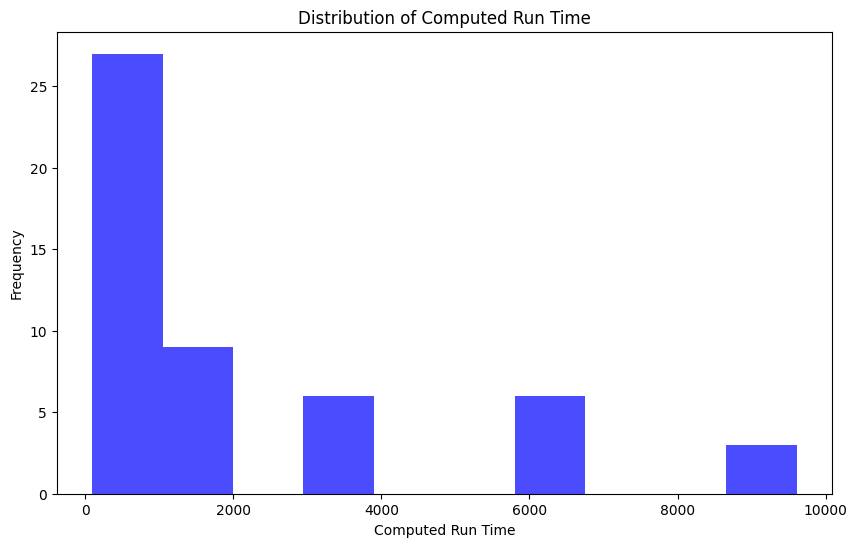

In [5]:
# plot the distrubution of the computed run time
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(stat_df['computed_run_time'], bins=10, alpha=0.7, color='blue')
plt.title('Distribution of Computed Run Time')
plt.xlabel('Computed Run Time')
plt.ylabel('Frequency')